# Stellar Mass Black Hole Companion

## Background

Here we will look at how to detect a stellar mass black hole in a binary system! This tutorial is HEAVILY inspired by Adrian Price-Whelan's [tutorial](https://thejoker.readthedocs.io/en/latest/examples/Thompson-black-hole.html) (most of the code is from there!), but don't look there for the answers!

Here we will be trying to repoduce the discovery from [Thompson et al. 2019](https://ui.adsabs.harvard.edu/abs/2019Sci...366..637T/abstract), who found a a stellar mass black hole in a binary system with a giant star in our Milky Way. We will combine their TRES radial velocity data with data from APOGEE to determine the orbital parameters of the system, including the binary mass!

## Data

Below we will add the approproiate imports and the data needed for the tutorial:

In [1]:
import arviz as az
import astropy.units as u
import corner
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import thejoker as tj
import thejoker.units as xu
from astropy.io import ascii
from astropy.time import Time
import os
%matplotlib inline
plt.style.use('../mystyle.mplstyle')

# set up a random number generator to ensure reproducibility
seed = 42
rnd = np.random.default_rng(seed=seed)

# data from Thompson et al; (2019)
tres_tbl = ascii.read(
    """8006.97517 0.000 0.075
    8023.98151 -43.313 0.075
    8039.89955 -27.963 0.045
    8051.98423 10.928 0.118
    8070.99556 43.782 0.075
    8099.80651 -30.033 0.054
    8106.91698 -42.872 0.135
    8112.81800 -44.863 0.088
    8123.79627 -25.810 0.115
    8136.59960 15.691 0.146
    8143.78352 34.281 0.087""",
    names=["HJD", "rv", "rv_err"],
)
tres_tbl["rv"].unit = u.km / u.s
tres_tbl["rv_err"].unit = u.km / u.s

# APOGEE data
apogee_tbl = ascii.read(
    """6204.95544 -37.417 0.011
    6229.92499 34.846 0.010
    6233.87715 42.567 0.010""",
    names=["HJD", "rv", "rv_err"],
)
apogee_tbl["rv"].unit = u.km / u.s
apogee_tbl["rv_err"].unit = u.km / u.s

To fit the orbit in this tutorial, we will be using [thejoker](https://thejoker.readthedocs.io/en/latest/index.html), which is a custom Monte Carlo sampler for the two-body problem. As a result, we will need to create some custom data objects that will be used by thejoker to do the sampling. This is done below.

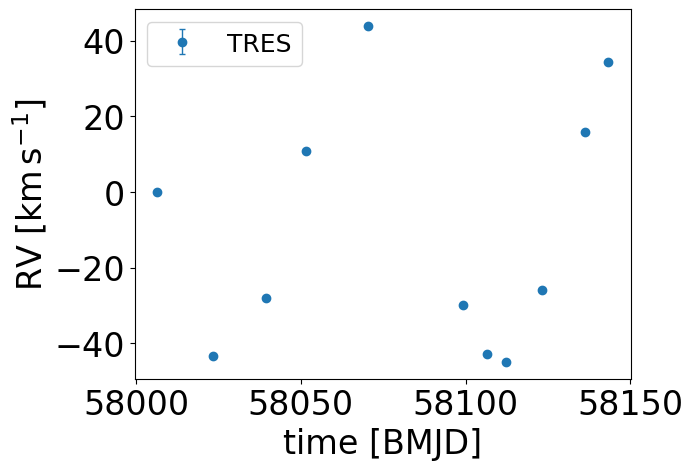

In [2]:
tres_data = tj.RVData(
    t=Time(tres_tbl["HJD"] + 2450000, format="jd", scale="tcb"),
    rv=u.Quantity(tres_tbl["rv"]),
    rv_err=u.Quantity(tres_tbl["rv_err"]),
)

apogee_data = tj.RVData(
    t=Time(apogee_tbl["HJD"] + 2450000, format="jd", scale="tcb"),
    rv=u.Quantity(apogee_tbl["rv"]),
    rv_err=u.Quantity(apogee_tbl["rv_err"]),
)

tres_data.plot(color=None, label="TRES")
plt.legend(fontsize=18)



## First, the TRES data

First, let us just fit the TRES data! Above we can see that the RV signal is periodic (yay!), but the errors are TINY (yes, they are there). thejoker allows you to add some non-linear parameters to the model, such as an extra uncertainty to the errors:
$$
\sigma_n = \sqrt{\sigma_{n,0}^2 + s ^2}
$$
This will just be one parameter in the model. thejoker also has some default priors for the other orbital paramters:
$$
p(P) \propto \frac{1}{P}; \ P:(P_{min}, P_{max})
$$
$$
p(e) = B(\alpha_e, b_e)
$$
$$
p(\omega) = \mathcal{U}(0, 2\pi)
$$
$$
p(M_0) = \mathcal{U}(0, 2\pi)
$$
$$
p(K) = \mathcal{N}(K|\mu_K, \sigma_K)
$$
$$
\sigma_K = \sigma_{K, 0} \left( \frac{P}{P_0}^{-1/3} \right) (1-e^2)^{-1/2}
$$
$$
p(v_0) = \mathcal{N}(v_0|\mu_{v_0}, \sigma_{v_0})
$$
So, in the above we are fitting the RV curve for the period ($P$), eccentricity ($e$), the pericenter phase ($M_0$) and argument ($\omega$), velocity semi-amplite ($K$) and barycenter velocity ($v_0$).

With the above in mind, below I will demonstrate how to set up the priors (including these default priors). Also, we will intially do rejection sampling of these distriubtions. Essentially, we unformily sample the priors and only accept the parameters if they match the data to some theshold. If enough samples survive this rejection criteria, we have a good estimate of the posterior! If not, we have a good starting point to run the MCMC.

In [3]:
with pm.Model() as model:
    # Allow extra error to account for under-estimated error bars
    s = xu.with_unit(pm.Lognormal("s", -2, 1), u.km / u.s)

    prior = tj.JokerPrior.default(
        P_min=16 * u.day,
        P_max=128 * u.day,  # Range of periods to consider
        sigma_K0=30 * u.km / u.s,
        P0=1 * u.year,  # scale of the prior on semiamplitude, K
        sigma_v=25 * u.km / u.s,  # std dev of the prior on the systemic velocity, v0
        s=s,
    )

# Generate a large number of prior samples:
prior_samples = prior.sample(size=1_000_000, rng=rnd)

# Run rejection sampling with The Joker:
joker = tj.TheJoker(prior, rng=rnd)
samples = joker.rejection_sample(tres_data, prior_samples, max_posterior_samples=256)

samples

<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>

Only one sample survived, but let's see how it looks compared to the Thompson et al. (2019) values:
$$
P = 83.205 \pm 0.064 \ days
$$
$$
e = 0.00476 \pm 0.00255
$$
$$
K = 44.615 \pm 0.123 \ km/s
$$

In [4]:
samples.tbl["P", "e", "K"]


P,e,K
d,,km / s
float64,float64,float64
83.2977327639342,0.008612274267935767,44.76966704707342


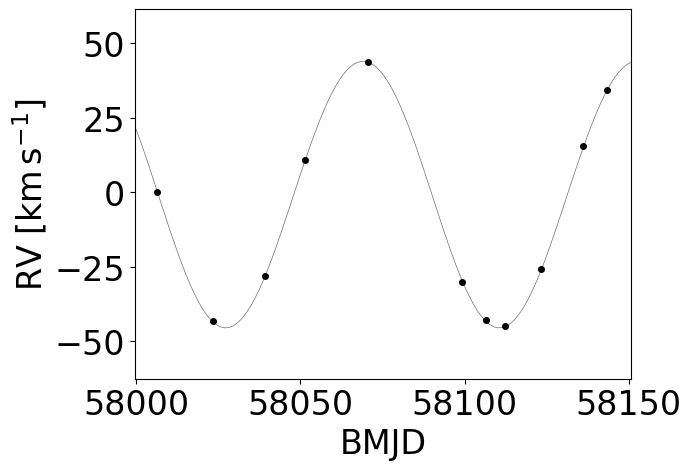

In [5]:
_ = tj.plot_rv_curves(samples, data=tres_data)



## Let's add the APOGEE data!

We have more data though! We also have some RV information from APOGEE we can use for the fit. The issue is these two spectrographs have a zero-point offset. So, we will need to add another parameter, which is an offset between the RVs of the two spectrographs. In the below cell, add this as a prior distribution models as a Gaussian with mean of 0 km/s and standard deviation of 5 km/s. Fill in the below code to set this up, run the rejection sample and plot the results!

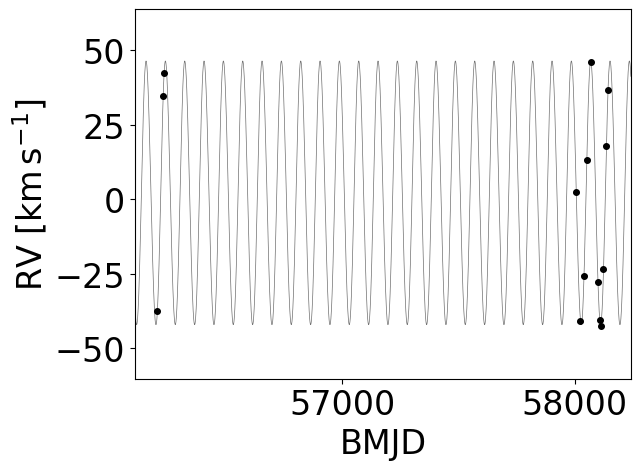

In [6]:
data = [apogee_data, tres_data]

with pm.Model() as model:
    # The parameter that represents the constant velocity offset between
    # APOGEE and TRES:
    dv0_1 = xu.with_unit(pm.Normal("dv0_1", 0, 5.0), u.km / u.s)

    # The same extra uncertainty parameter as previously defined
    s = xu.with_unit(pm.Lognormal("s", -2, 1), u.km / u.s)

    # We can restrict the prior on prior now, using the above
    prior_joint = tj.JokerPrior.default(
        # P_min=16*u.day, P_max=128*u.day,
        P_min=75 * u.day,
        P_max=90 * u.day,
        sigma_K0=30 * u.km / u.s,
        P0=1 * u.year,
        sigma_v=25 * u.km / u.s,
        v0_offsets=[dv0_1],
        s=s,
    )

prior_samples_joint = prior_joint.sample(size=1_000_000, rng=rnd)

# Run rejection sampling with The Joker:
joker_joint = tj.TheJoker(prior_joint, rng=rnd)
samples_joint = joker_joint.rejection_sample(
    data, prior_samples_joint, max_posterior_samples=256
)

_ = tj.plot_rv_curves(samples_joint, data=data)



## Run full MCMC!

Let's trying running a full MCMC with this though to visualize the posterior distirubtion. For a Keplarian Orbit, angles are hard for samples to deal with. That is why we will do two things. First, we want to use `pymc3_ext.distributions.angle`, which samples over $cos(x)$ and $sin(x)$ instead. Additionally, we will want to sample over $M_0 - \omega$ and $\omega$, instead of $M_0$ and $\omega$. Then, we will be able to use the rejection sample from the above to initialze the MCMC and run things! Some of the code is filled out by me below, but working on filling in the missing bits based on what I have said above!

In [7]:
from pymc_ext.distributions import angle

with pm.Model():
    # See note above: when running MCMC, we will sample in the parameters
    # (M0 - omega, omega) instead of (M0, omega)
    M0_m_omega = xu.with_unit(angle("M0_m_omega"), u.radian)
    omega = xu.with_unit(angle("omega"), u.radian)

    M0 = xu.with_unit(pm.Deterministic("M0", M0_m_omega + omega), u.radian)

    # The same offset and extra uncertainty parameters as above:
    dv0_1 = xu.with_unit(pm.Normal("dv0_1", 0, 5.0), u.km / u.s)
    s = xu.with_unit(pm.Lognormal("s", -2, 0.5), u.km / u.s)

    prior_mcmc = tj.JokerPrior.default(
        P_min=16 * u.day,
        P_max=128 * u.day,
        sigma_K0=30 * u.km / u.s,
        P0=1 * u.year,
        sigma_v=25 * u.km / u.s,
        v0_offsets=[dv0_1],
        s=s,
        pars={"M0": M0, "omega": omega},
    )

    joker_mcmc = tj.TheJoker(prior_mcmc, rng=rnd)
    mcmc_init = joker_mcmc.setup_mcmc(data, samples_joint)

    trace = pm.sample(
        tune=1000, draws=500, start=mcmc_init, random_seed=seed, cores=1, chains=2
    )


/var/folders/17/d8lt9wb91k9bsvm5vm9g6q3w0000gn/T/ipykernel_25998/905608449.py:29: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [__M0_m_omega_angle1, __M0_m_omega_angle2, __omega_angle1, __omega_angle2, dv0_1, s, e, P, K, v0]


/Users/imedan/anaconda3/envs/emit_tutorial/lib/python3.11/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 18 seconds.
There were 46 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


With this done, we can now look at the results!

In [8]:
# get the samples
mcmc_samples = tj.JokerSamples.from_inference_data(prior_joint, trace, data=data)
mcmc_samples = mcmc_samples.wrap_K()
df = mcmc_samples.tbl.to_pandas()

# look at summary table
az.summary(trace, var_names=prior_mcmc.par_names)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,83.161,0.015,83.132,83.191,0.001,0.001,261.0,319.0,1.00
e,0.003,0.002,0.000,0.007,0.000,0.000,392.0,371.0,1.00
omega,0.462,0.972,-1.601,2.222,0.051,0.050,374.0,382.0,1.01
M0,-0.039,0.971,-2.094,1.744,0.051,0.049,380.0,398.0,1.01
s,0.226,0.052,0.141,0.318,0.003,0.002,366.0,414.0,1.00
K,-44.729,0.104,-44.907,-44.520,0.005,0.004,442.0,502.0,1.00
v0,2.163,0.637,0.894,3.335,0.040,0.033,257.0,361.0,1.00
dv0_1,-2.611,0.654,-3.777,-1.252,0.041,0.033,255.0,305.0,1.00


The dataframe above now has all of our samples! Use this and the corner package to plot the resulting MCMC samples

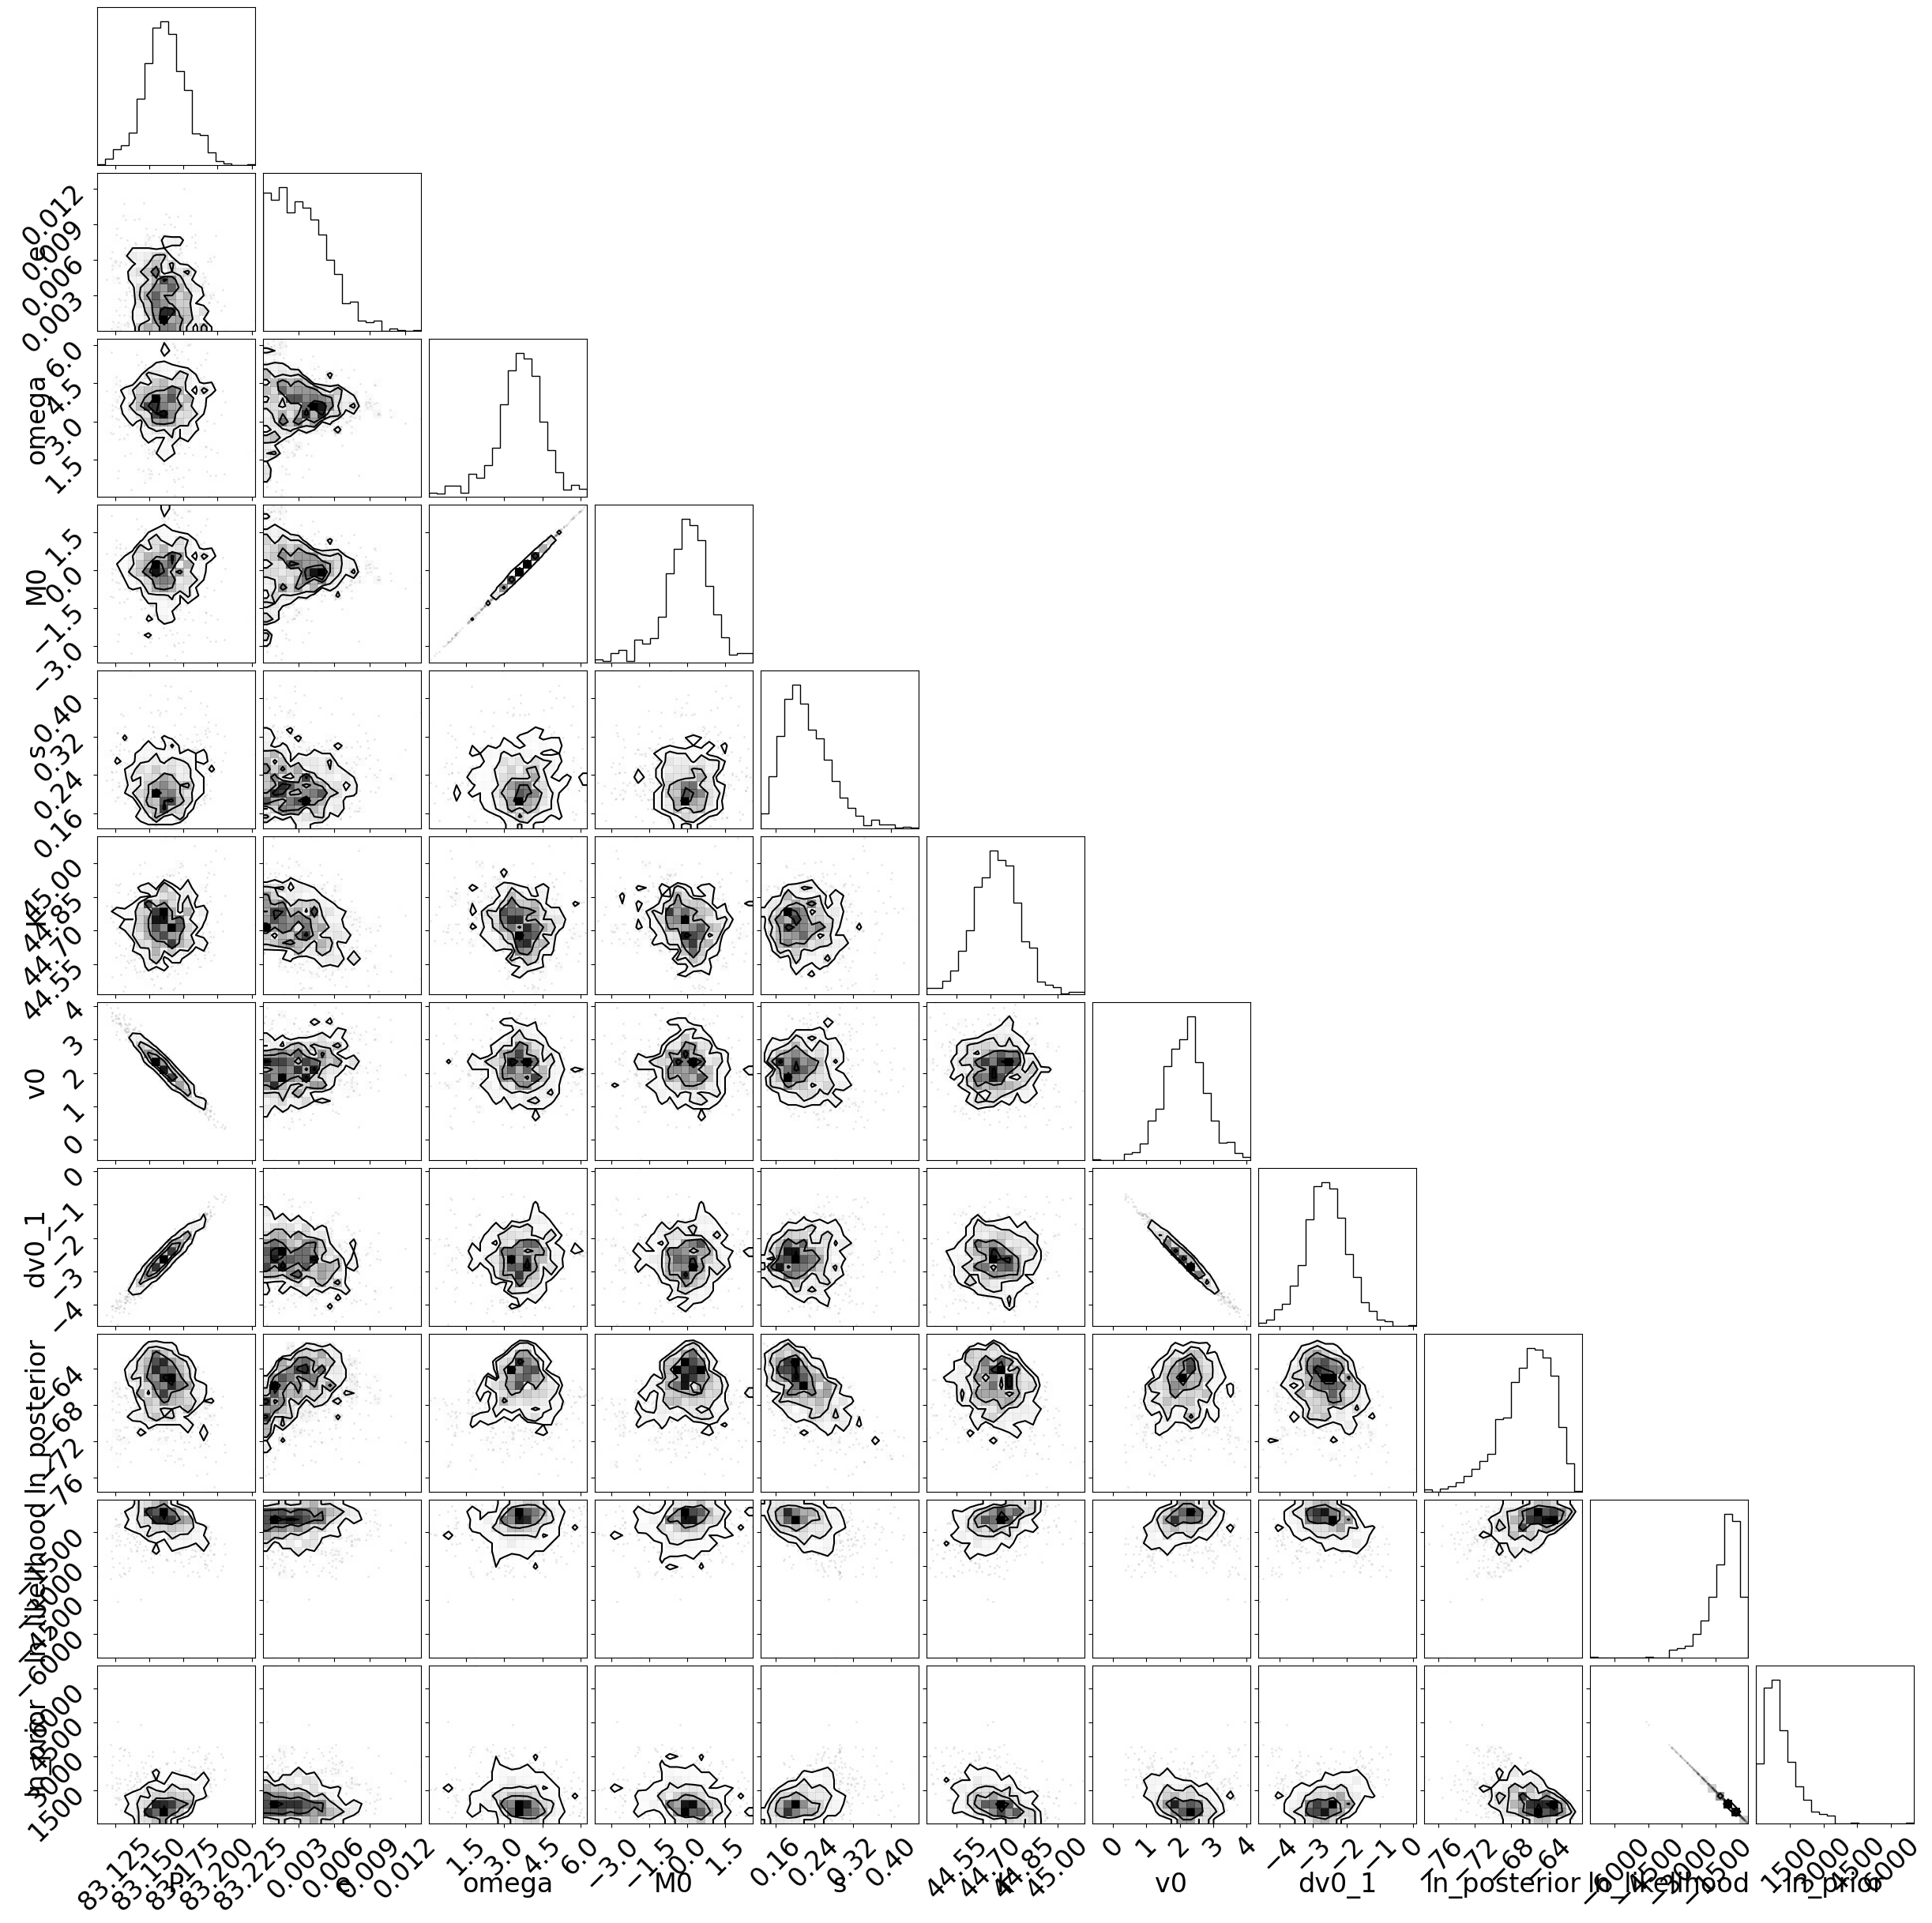

In [9]:
_ = corner.corner(df)


Finally, we can look at the binary mass function for the system:
$$
f(M) = \frac{M_2^3 sin^3i}{(M_1 + M_2)^2}
$$
This can accessed for each sample like: `mcmc_samples.get_orbit(i).m_f`. Below, sample 1000 of the random orbits and plot their distirbuton! See how it compares the Thompson et al. (2019); $f(M) = 0.766 \pm 0.00637$

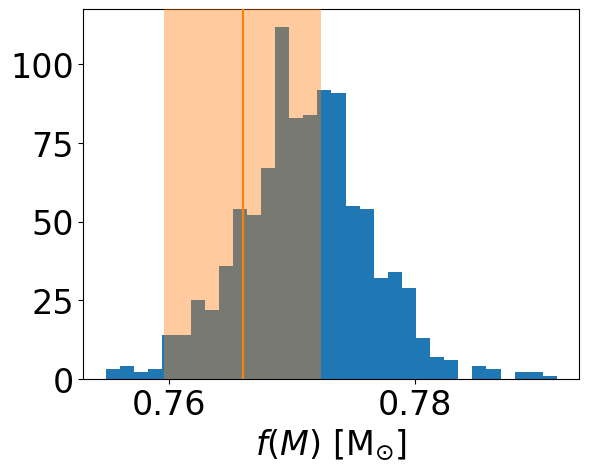

In [10]:
mfs = u.Quantity(
    [mcmc_samples.get_orbit(i).m_f for i in rnd.choice(len(mcmc_samples), 1000)]
)

plt.hist(mfs.to_value(u.Msun), bins=32)
plt.xlabel(rf"$f(M)$ [{u.Msun:latex_inline}]")
# Values from Thompson et al., showing 1-sigma region
plt.axvline(0.766, zorder=100, color="tab:orange")
plt.axvspan(
    0.766 - 0.00637, 0.766 + 0.00637, zorder=10, color="tab:orange", alpha=0.4, lw=0
)


So, this is in pretty good agreement and we see that there is a large mass companion!